In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9698
meniskus-urgent             9226
cruciate-ligament-urgent    2382
meniskus-minor              1663
cruciate-ligament-minor      355
Name: count, dtype: int64


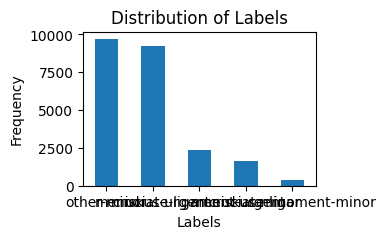

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')
df_train = df_train.dropna(subset=['data'])
df_valid = df_valid.dropna(subset=['data'])
df_test = df_test.dropna(subset=['data'])

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:
model_name = "final"

In [5]:
import tensorflow as tf
import numpy as np

def cyclic_learning_rate(epoch, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular'):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    if mode == 'triangular':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    elif mode == 'triangular2':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x)) / float(2**(cycle-1))
    elif mode == 'exp_range':
        return base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x)) * (0.999**(epoch))
    else:
        raise ValueError('Invalid mode: {}'.format(mode))
    
def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [6]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()
clr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: cyclic_learning_rate(epoch, base_lr=10**-3.5, max_lr=0.2, step_size=2000, mode='triangular'))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(schedule=lr_schedule)


# Model definition and training

In [6]:
# from tensorflow.keras.layers import Conv1D
# from tensorflow.keras.layers import Attention, Flatten, BatchNormalization




# # Define the input layer
# input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# # Embedding layer
# x = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# # Two LSTM layers
# x = Conv1D(filters=128, kernel_size=10, activation='relu')(x)
# x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
# x = BatchNormalization()(x)

# # Applying Attention Mechanism
# query, value = x, x
# attention = Attention()([query, value])
# x = Flatten()(attention)

# x = Dense(units=64, activation='relu')(x)

# # Output layer
# output = Dense(num_classes, activation='softmax')(x)

# # Define the model
# model = Model(inputs=input_text, outputs=output)

# # Compile the model
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
#                     validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

In [7]:
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, BatchNormalization, Dropout, Attention, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner import HyperModel, BayesianOptimization 

callbacks_1 = [early_stopping_callback]
callbacks_2 = [early_stopping_callback, clr]
callbacks_3 = [early_stopping_callback, lr_schedule]

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        # Define the input layer
        input_text = Input(shape=(max_length,), dtype='int32', name='text_input')
        
        # Embedding layer
        x = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)
        
        # Optional Conv1D layer
        if hp.Boolean('conv1d'):
            x = Conv1D(filters=hp.Int('conv1d_filters', 64, 256, step=64),
                    kernel_size=hp.Int('conv1d_kernel_size', 3, 10),
                    activation='relu')(x)
        
        # LSTM layers with options for batch normalization and dropout
        for i in range(hp.Int('num_lstm_layers', 1, 3)):
            x = Bidirectional(LSTM(units=hp.Int('lstm_units', 32, 128, step=32), return_sequences=True))(x)
            if hp.Boolean('batch_normalization'):
                x = BatchNormalization()(x)
            if hp.Boolean('dropout'):
                x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
        
        # Optional Attention Mechanism
        if hp.Boolean('attention'):
            query, value = x, x
            attention = Attention()([query, value])
            x = Flatten()(attention)
        else:
            x = GlobalMaxPooling1D()(x)  # GlobalMaxPooling1D to reduce dimensions
        
        # Dense layer
        if hp.Boolean('dense'):
            x = Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu')(x)
        
        # Output layer


        output = Dense(num_classes, activation='softmax')(x)
        
        # Define the model
        model = Model(inputs=input_text, outputs=output)
        
        # Compile the model
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
                    loss=loss,
                    metrics=metrics)
        
        return model

    def fit(self, hp, model, *args, **kwargs):
        # Select callbacks based on hyperparameter choice
        callbacks_1 = [EarlyStopping(monitor='val_loss', patience=3)]
        clr = ...  # Define your cyclical learning rate callback
        lr_schedule = ...  # Define your learning rate schedule callback
        callbacks_2 = [EarlyStopping(monitor='val_loss', patience=3), clr]
        callbacks_3 = [EarlyStopping(monitor='val_loss', patience=3), lr_schedule]
        
        callbacks_list = [callbacks_1, callbacks_2, callbacks_3]
        selected_callbacks = callbacks_list[hp.Choice('callbacks', [0, 1, 2])]
        
        return model.fit(
            *args,
            batch_size=hp.Int('batch_size', min_value=32, max_value=128, step=32),
            #callbacks=selected_callbacks,
            **kwargs,
        )

# Set up the tuner with the RandomSearch algorithm
tuner = BayesianOptimization(
    LSTMHyperModel(),
    objective=kt.Objective("val_f1_score", "max"),
    max_trials=30,
    executions_per_trial=1,
    directory='model_tuning',
    project_name='final'
)

# Search for the best hyperparameters
tuner.search(train_padded, train_labels, 
             epochs=30, 
             validation_data=(valid_padded, valid_labels),
             callbacks=callbacks_1)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters found:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")

Trial 30 Complete [00h 51m 23s]
val_f1_score: 0.6162659525871277

Best val_f1_score So Far: 0.7048892378807068
Total elapsed time: 1d 14h 37m 18s
Best hyperparameters found:
conv1d: False
num_lstm_layers: 2
lstm_units: 128
batch_normalization: False
dropout: False
attention: False
dense: False
learning_rate: 0.001703295371026577
conv1d_filters: 256
conv1d_kernel_size: 5
dense_units: 96
callbacks: 0
batch_size: 96
dropout_rate: 0.2


246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step


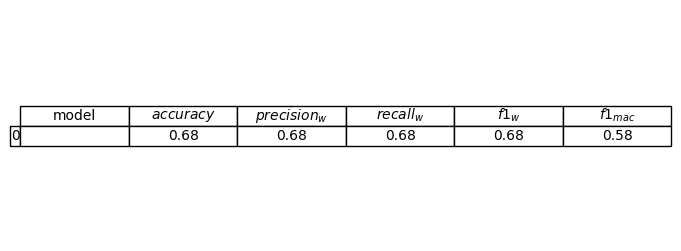

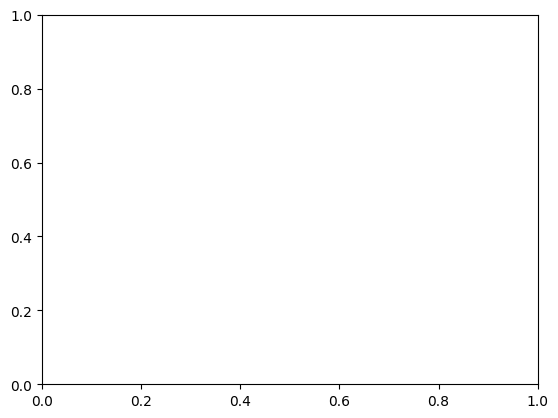

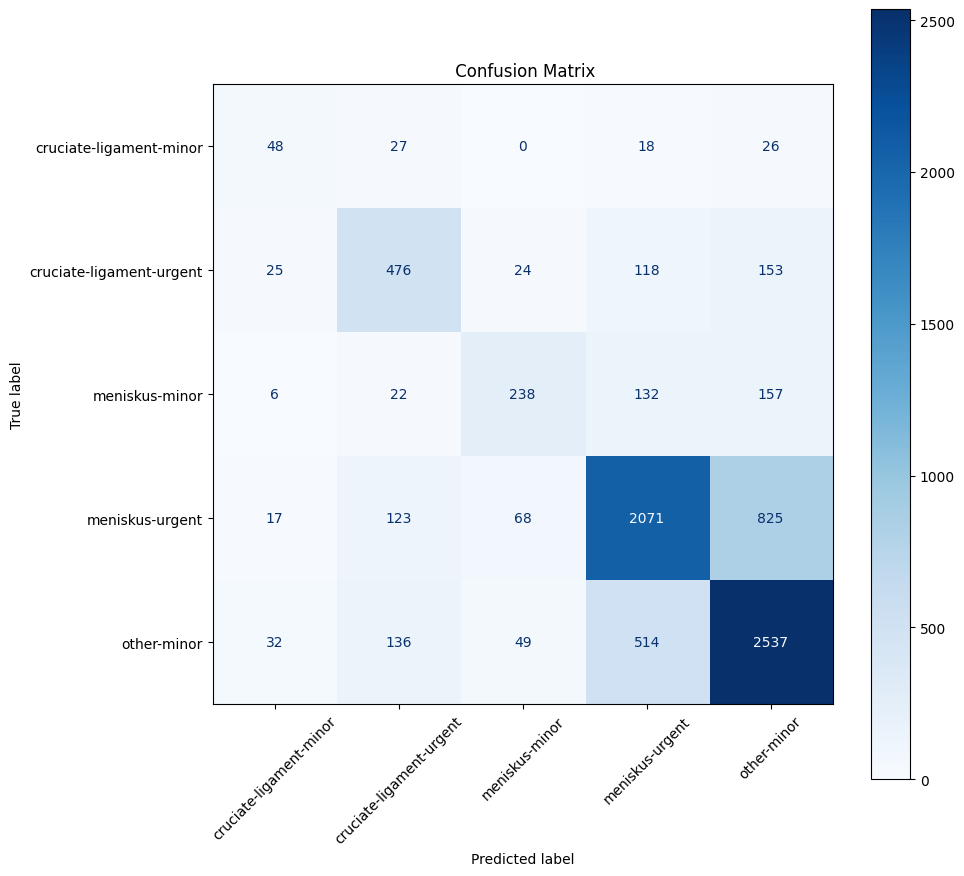

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.68,0.68,0.68,0.68,0.58


In [ ]:
eval(model, test_padded, test_labels, label_encoder)

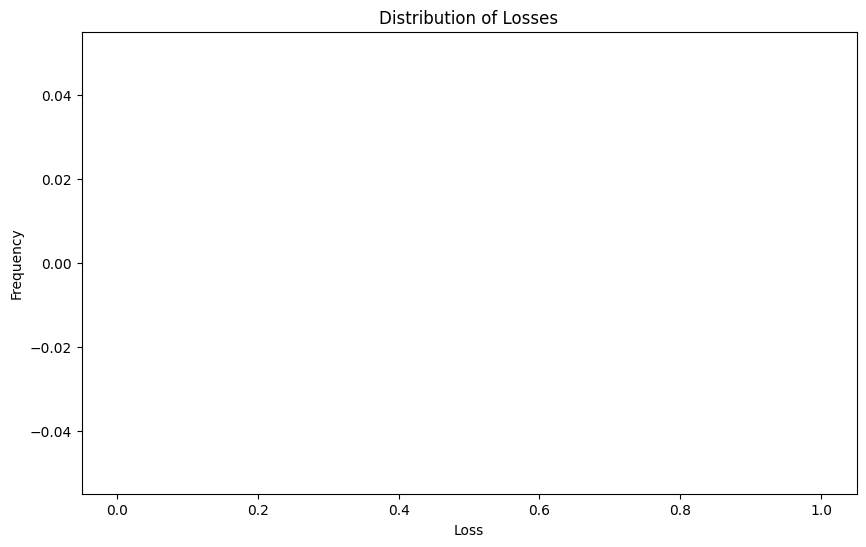

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [ ]:
losses = list(filter(lambda item: item is not None, loss_history.losses))
plt.figure(figsize=(10, 6))
plt.hist(losses, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()
print(loss_history.losses)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step
Indices of most problematic samples: [3284 2576 4541 5828 3280 2610 4509 5553 3296 7477]
Loss values of most problematic samples: [16.118095 16.118095 16.118095 16.118095 16.118095 16.118095 16.118095
 16.118095 16.118095 16.118095]


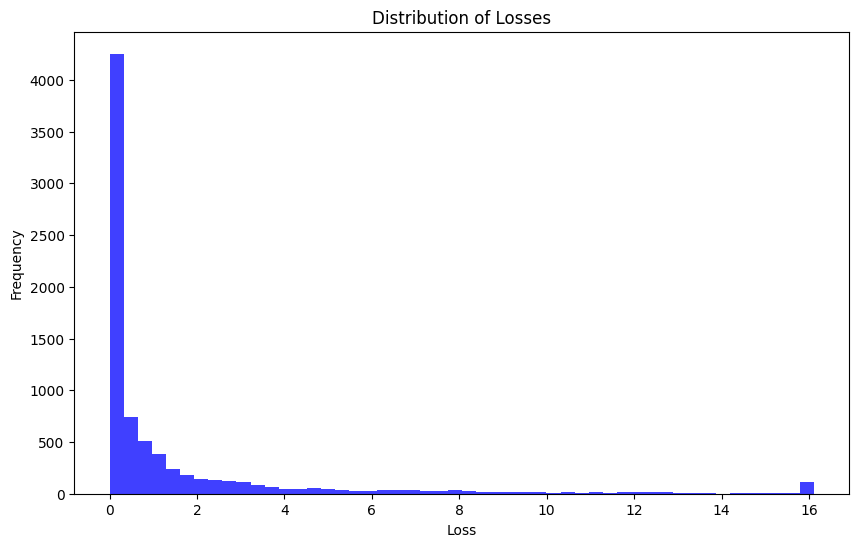

In [ ]:
# Function to calculate loss per sample
def calculate_loss_per_sample(model, x, y):
    predictions = model.predict(x)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    losses = loss_fn(y, predictions)
    return losses.numpy()

# Calculate losses for each sample
sample_losses = calculate_loss_per_sample(model, valid_padded, valid_labels)

# Find indices of the highest losses
num_problematic = 10  # Number of problematic samples to identify
problematic_indices = np.argsort(sample_losses)[-num_problematic:]

# Print the most problematic samples
print("Indices of most problematic samples:", problematic_indices)
print("Loss values of most problematic samples:", sample_losses[problematic_indices])
plt.figure(figsize=(10, 6))
plt.hist(sample_losses, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Optional: Analyze the problematic samples
for index in problematic_indices:
    print(f"Sample {index} - Features: {df_train.iloc[index]['data']}, Label: {label_encoder.inverse_transform([np.argmax(train_labels[index])])}, Loss: {sample_losses[index]}")

Sample 3284 - Features: . Mein rechtes Knie kann nicht überstreckt werden und es gibt auch kein Streckdefizit. Die Beugung des Knies ist gut möglich. Mein Knie ist nicht geschwollen. Es gibt einen Bandruckschmerz und einen deutlichen Druckschmerz auf der medialen Seite des Kniegelenks und eine diskrete Druckschmerz auf der äußerechts Seite des Kniegelenks., Label: ['other-minor'], Loss: 16.11809539794922
Sample 2576 - Features: 35.0 Jahre alt männlich seit 10/02 progente Kniebeschwerden li. mit Schwellneigung und Belastungsschemrzen. Mein linkes Knie hat Schmerzen auf der inneren Seite, aber es gibt keinen wesentlichen Gelenkerguss., Label: ['other-minor'], Loss: 16.11809539794922
Sample 4541 - Features: 52.0 Jahre alt weiblich Faszienrolle und Physio begonnen; ESWt tat sehr gut. Mein Gangbild ist flüssig, und ich habe leichte Schmerzen im rechten Kniegelenk, wenn ich auf der medialen Seite drücke. Es gibt keinen Druckschmerz auf der äußeren Seite des Kniegelenks und der Kniescheibe., 

In [ ]:
df_train.iloc[6513]

Unnamed: 0.3                                                    6568
Unnamed: 0.2                                                    6568
Unnamed: 0.1                                                    6568
Unnamed: 0                                                      3172
patientid                                                    27596.0
sex                                                             male
age                                                             32.0
ANA                Seit mehreren Monaten Gonalgie re.; Belastungs...
EXA                re. Knie: physiologsche Beinachsen; Muskuläres...
DIA_text            Z.n.arthroskopischer Chirurgie des Kniegelenkes.
DIA_code                                                    M23.3- Z
OP_text                                                          NaN
OP_code                                                          NaN
EXA_formatted      mässiger gelenkerguß, druckschmerz innereer se...
EXA_interpreted    Mein Knie hat e

In [ ]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/final/final.h5
Data saved


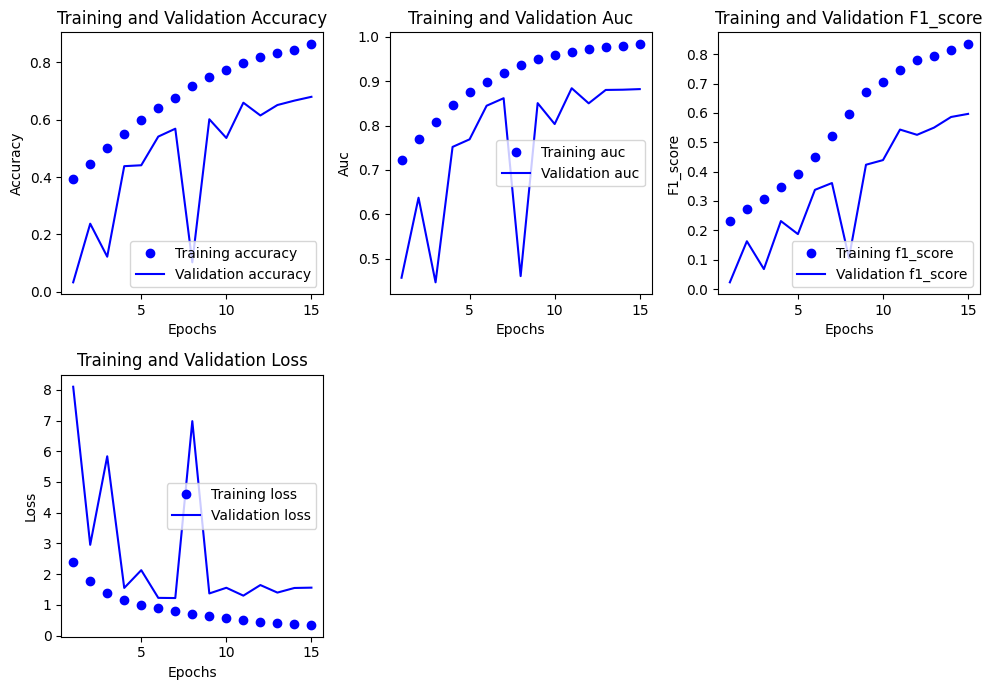

In [ ]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step


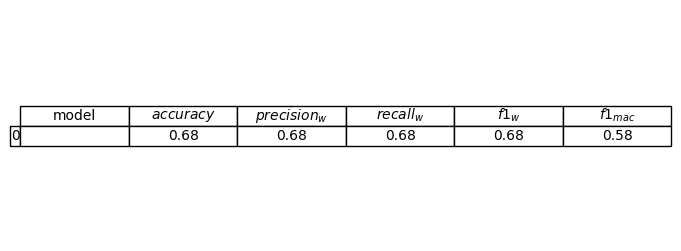

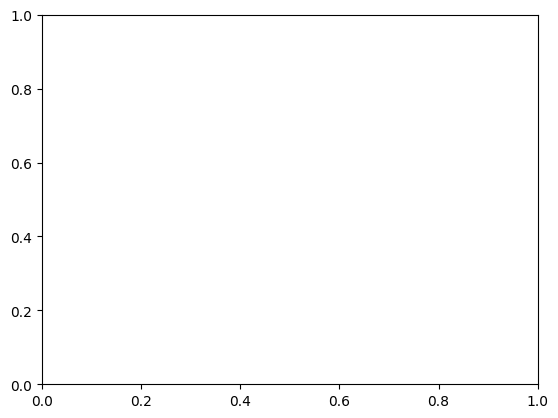

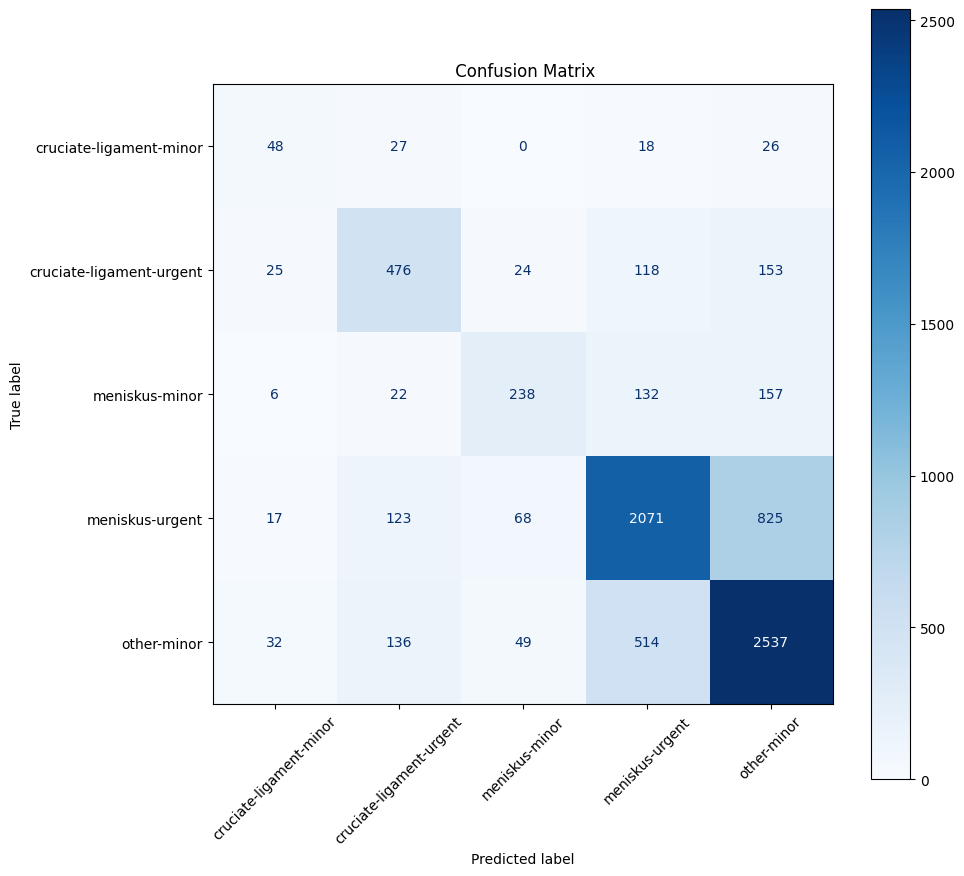

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.68,0.68,0.68,0.68,0.58


In [ ]:
eval(model, test_padded, test_labels, label_encoder)